In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Load the training and testing sets
unsw_train = pd.read_csv('CSV Files/Training and Testing Sets/UNSW_NB15_training-set.csv')
unsw_test = pd.read_csv('CSV Files/Training and Testing Sets/UNSW_NB15_testing-set.csv')

# Display basic information
print("Training set shape:", unsw_train.shape)
print("Testing set shape:", unsw_test.shape)
print("\nTraining set info:")
print(unsw_train.info())
print("\nFirst few rows of training set:")
print(unsw_train.head())

Training set shape: (175341, 45)
Testing set shape: (82332, 45)

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss           

In [11]:
# Check class distribution
print("\nTraining set label distribution:")
print(unsw_train['label'].value_counts(normalize=True))
print("\nTesting set label distribution:")
print(unsw_test['label'].value_counts(normalize=True))


Training set label distribution:
label
1    0.680622
0    0.319378
Name: proportion, dtype: float64

Testing set label distribution:
label
1    0.5506
0    0.4494
Name: proportion, dtype: float64


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Identify numeric and categorical columns before encoding
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = ['proto', 'state', 'service']


# Drop problematic features
columns_to_drop = ['id', 'srcip', 'sport', 'dstip', 'dsport', 'Stime', 'Ltime', 'stcpb', 'dtcpb', 'attack_cat']
unsw_train = unsw_train.drop(columns=columns_to_drop, errors='ignore')
unsw_test = unsw_test.drop(columns=columns_to_drop, errors='ignore')

# Encode categorical features
unsw_train = pd.get_dummies(unsw_train, columns=categorical_cols, drop_first=True)
unsw_test = pd.get_dummies(unsw_test, columns=categorical_cols, drop_first=True)

# Align columns
unsw_train, unsw_test = unsw_train.align(unsw_test, join='inner', axis=1)

# Separate features and labels
X_train = unsw_train.drop('label', axis=1)
y_train = unsw_train['label']
X_test = unsw_test.drop('label', axis=1)
y_test = unsw_test['label']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', 'passthrough', [col for col in X_train.columns if col not in numeric_cols])
    ])

# Apply the preprocessor
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(X_train_scaled.head(2))

        dur     spkts     dpkts    sbytes    dbytes      rate      sttl  \
0 -0.191029 -0.104456 -0.135769 -0.049134 -0.102726 -0.576371  0.703839   
1 -0.109485 -0.046014  0.172599 -0.046410  0.188544 -0.576345 -1.141901   

       dttl     sload     dload  ...  service_ftp  service_ftp-data  \
0  1.578100 -0.389897 -0.273700  ...          0.0               0.0   
1  1.560002 -0.389928 -0.069233  ...          0.0               0.0   

   service_http  service_irc  service_pop3  service_radius  service_smtp  \
0           0.0          0.0           0.0             0.0           0.0   
1           0.0          0.0           0.0             0.0           0.0   

   service_snmp  service_ssh  service_ssl  
0           0.0          0.0          0.0  
1           0.0          0.0          0.0  

[2 rows x 183 columns]


In [14]:
X_train_scaled.head()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,-0.191029,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,1.578100,-0.389897,-0.273700,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.109485,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,1.560002,-0.389928,-0.069233,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.040699,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,1.560002,-0.389964,-0.252044,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.049729,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,1.560002,-0.389958,-0.275821,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.140417,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,1.560002,-0.389927,-0.275561,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Training Random Forest...

Classification Report for Random Forest:
              precision    recall  f1-score   support

      Normal       0.98      0.73      0.84     37000
      Attack       0.82      0.99      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.90      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332


Training XGBoost...

Classification Report for XGBoost:
              precision    recall  f1-score   support

      Normal       0.96      0.74      0.84     37000
      Attack       0.82      0.98      0.89     45332

    accuracy                           0.87     82332
   macro avg       0.89      0.86      0.87     82332
weighted avg       0.89      0.87      0.87     82332


Training Logistic Regression...

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      Normal       0.95      0.61      0.74     37000
      Attack       0.75      0

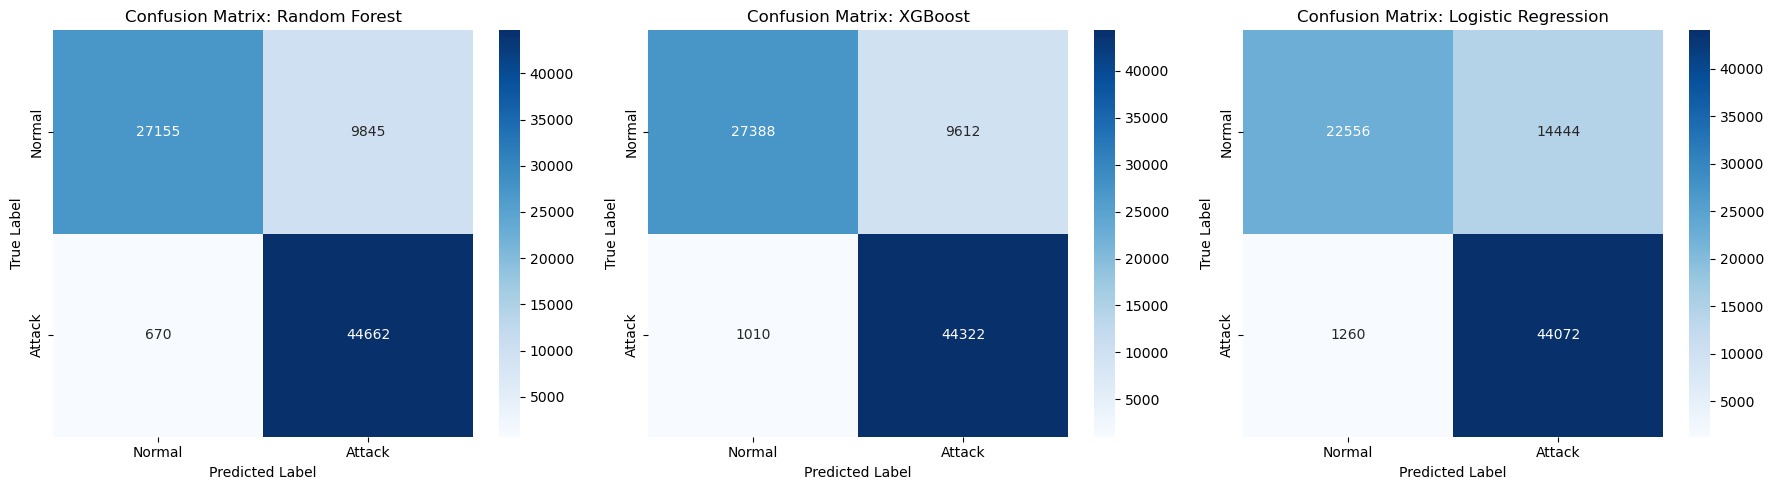

In [16]:
# Define the models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Dictionary to store results
results = {
    'Model': [],
    'Accuracy': [],
    'Precision (macro)': [],
    'Recall (macro)': [],
    'F1-score (macro)': []
}

# Dictionary to store confusion matrices
confusion_matrices = {}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_scaled)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Store metrics
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision (macro)'].append(precision)
    results['Recall (macro)'].append(recall)
    results['F1-score (macro)'].append(f1)
    
    # Compute and store confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[model_name] = cm
    
    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

# Create a DataFrame to display results
results_df = pd.DataFrame(results)
print("\nComparison of Models:")
print(results_df)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    axes[idx].set_title(f'Confusion Matrix: {model_name}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()


Training Random Forest with SMOTE...

Classification Report for Random Forest with SMOTE:
              precision    recall  f1-score   support

      Normal       0.97      0.77      0.86     37000
      Attack       0.84      0.98      0.90     45332

    accuracy                           0.89     82332
   macro avg       0.90      0.88      0.88     82332
weighted avg       0.90      0.89      0.88     82332


Training XGBoost with SMOTE...

Classification Report for XGBoost with SMOTE:
              precision    recall  f1-score   support

      Normal       0.97      0.78      0.86     37000
      Attack       0.84      0.98      0.91     45332

    accuracy                           0.89     82332
   macro avg       0.91      0.88      0.89     82332
weighted avg       0.90      0.89      0.89     82332


Training Logistic Regression with SMOTE...

Classification Report for Logistic Regression with SMOTE:
              precision    recall  f1-score   support

      Normal      

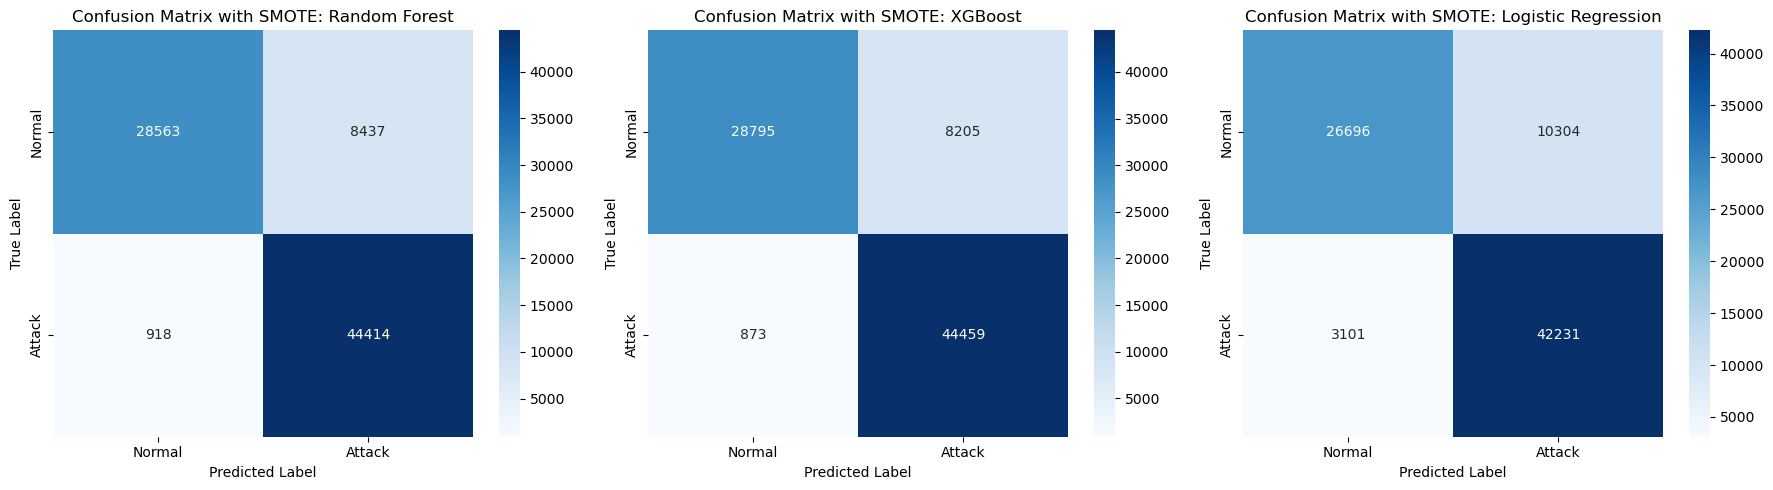

In [17]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Retrain and evaluate models
results_smote = {
    'Model': [],
    'Accuracy': [],
    'Precision (macro)': [],
    'Recall (macro)': [],
    'F1-score (macro)': []
}
confusion_matrices_smote = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name} with SMOTE...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Store metrics
    results_smote['Model'].append(model_name)
    results_smote['Accuracy'].append(accuracy)
    results_smote['Precision (macro)'].append(precision)
    results_smote['Recall (macro)'].append(recall)
    results_smote['F1-score (macro)'].append(f1)
    
    # Compute and store confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices_smote[model_name] = cm
    
    # Print classification report
    print(f"\nClassification Report for {model_name} with SMOTE:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

# Display results
results_smote_df = pd.DataFrame(results_smote)
print("\nComparison of Models with SMOTE:")
print(results_smote_df)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for idx, (model_name, cm) in enumerate(confusion_matrices_smote.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    axes[idx].set_title(f'Confusion Matrix with SMOTE: {model_name}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=300, reg_lambda=0, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_res, y_train_res)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Probability of Attack
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1-score:", best_threshold)

# Predict with new threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)
print("\nClassification Report for XGBoost with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Normal', 'Attack']))

Best threshold for F1-score: 0.8174815

Classification Report for XGBoost with Adjusted Threshold:
              precision    recall  f1-score   support

      Normal       0.91      0.93      0.92     37000
      Attack       0.95      0.93      0.94     45332

    accuracy                           0.93     82332
   macro avg       0.93      0.93      0.93     82332
weighted avg       0.93      0.93      0.93     82332



In [27]:
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'reg_lambda': [0, 1]
}
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)
print("Best parameters:", grid_search.best_params_)
print("Best F1-score (macro):", grid_search.best_score_)

best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)
print("\nClassification Report for Tuned XGBoost:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

c:\Users\soka1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\soka1\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\soka1\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\soka1\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1580, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                          

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'reg_lambda': 0}
Best F1-score (macro): 0.9336400130178767

Classification Report for Tuned XGBoost:
              precision    recall  f1-score   support

      Normal       0.97      0.78      0.86     37000
      Attack       0.85      0.98      0.91     45332

    accuracy                           0.89     82332
   macro avg       0.91      0.88      0.89     82332
weighted avg       0.90      0.89      0.89     82332



In [21]:
xgb_model = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=300, reg_lambda=0, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_res, y_train_res)
xgb_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': xgb_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
print("\nXGBoost Feature Importance (Top 10):")
print(importance_df.head(10))

# Select top features (e.g., top 20)
top_features = importance_df['Feature'].head(20).tolist()
X_train_selected = X_train_res[top_features]
X_test_selected = X_test_scaled[top_features]

# Retrain XGBoost on selected features
xgb_model.fit(X_train_selected, y_train_res)
y_pred = xgb_model.predict(X_test_selected)
print("\nClassification Report for XGBoost with Selected Features:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))


XGBoost Feature Importance (Top 10):
              Feature  Importance
6                sttl    0.682206
29   ct_dst_sport_ltm    0.034770
35         ct_srv_dst    0.028545
16               swin    0.025829
154        proto_unas    0.022654
21              smean    0.018012
3              sbytes    0.015077
172       service_dns    0.013915
26       ct_state_ttl    0.011810
30     ct_dst_src_ltm    0.009078

Classification Report for XGBoost with Selected Features:
              precision    recall  f1-score   support

      Normal       0.97      0.79      0.87     37000
      Attack       0.85      0.98      0.91     45332

    accuracy                           0.89     82332
   macro avg       0.91      0.88      0.89     82332
weighted avg       0.90      0.89      0.89     82332



In [25]:
from sklearn.metrics import precision_recall_curve

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=300, reg_lambda=0, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_res, y_train_res)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]  # Probability of Attack
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1-score:", best_threshold)

# Predict with new threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)
print("\nClassification Report for XGBoost with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted, target_names=['Normal', 'Attack']))

Best threshold for F1-score: 0.8174815

Classification Report for XGBoost with Adjusted Threshold:
              precision    recall  f1-score   support

      Normal       0.91      0.93      0.92     37000
      Attack       0.95      0.93      0.94     45332

    accuracy                           0.93     82332
   macro avg       0.93      0.93      0.93     82332
weighted avg       0.93      0.93      0.93     82332



In [23]:
param_grid = {
    'n_estimators': [300],
    'max_depth': [6],
    'learning_rate': [0.1],
    'reg_lambda': [1, 2, 5]
}
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)
print("Best parameters:", grid_search.best_params_)
print("Best F1-score (macro):", grid_search.best_score_)

best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test_scaled)
print("\nClassification Report for Tuned XGBoost (Round 3 - Regularization):")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))

Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'reg_lambda': 1}
Best F1-score (macro): 0.9332257146058208

Classification Report for Tuned XGBoost (Round 3 - Regularization):
              precision    recall  f1-score   support

      Normal       0.97      0.78      0.87     37000
      Attack       0.85      0.98      0.91     45332

    accuracy                           0.89     82332
   macro avg       0.91      0.88      0.89     82332
weighted avg       0.90      0.89      0.89     82332



In [24]:
xgb_weighted = XGBClassifier(scale_pos_weight=sum(y_train == 0) / sum(y_train == 1), eval_metric='logloss', random_state=42)
xgb_weighted.fit(X_train_scaled, y_train)
y_pred = xgb_weighted.predict(X_test_scaled)
print("\nClassification Report for XGBoost with Class Weights:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))


Classification Report for XGBoost with Class Weights:
              precision    recall  f1-score   support

      Normal       0.94      0.83      0.89     37000
      Attack       0.88      0.96      0.92     45332

    accuracy                           0.90     82332
   macro avg       0.91      0.90      0.90     82332
weighted avg       0.91      0.90      0.90     82332



Best threshold for F1-score: 0.69376695

Classification Report for XGBoost (Class Weights + Feature Selection + Adjusted Threshold):
              precision    recall  f1-score   support

      Normal       0.92      0.93      0.93     37000
      Attack       0.94      0.93      0.94     45332

    accuracy                           0.93     82332
   macro avg       0.93      0.93      0.93     82332
weighted avg       0.93      0.93      0.93     82332



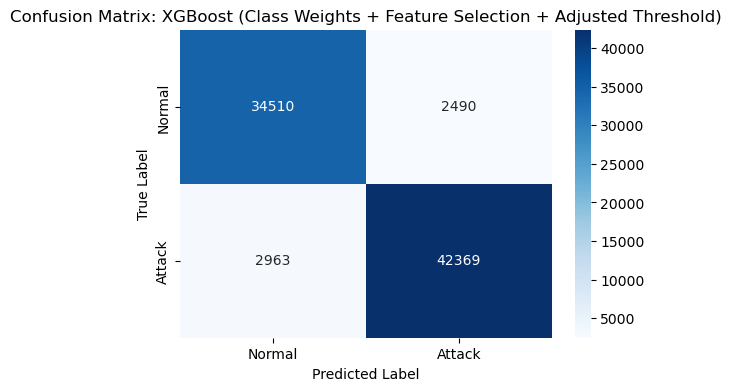

In [26]:
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train XGBoost with Class Weights and Top 20 Features
xgb_weighted = XGBClassifier(scale_pos_weight=sum(y_train == 0) / sum(y_train == 1), eval_metric='logloss', random_state=42)
xgb_weighted.fit(X_train_scaled, y_train)

# Feature Importance
xgb_importance = xgb_weighted.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': xgb_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
top_features = importance_df['Feature'].head(20).tolist()

# Select top 20 features
X_train_selected = X_train_scaled[top_features]
X_test_selected = X_test_scaled[top_features]

# Retrain on selected features
xgb_weighted.fit(X_train_selected, y_train)

# Step 2: Adjust Decision Threshold
y_pred_proba = xgb_weighted.predict_proba(X_test_selected)[:, 1]  # Probability of Attack
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1-score:", best_threshold)

# Predict with new threshold
y_pred_adjusted = (y_pred_proba >= best_threshold).astype(int)
print("\nClassification Report for XGBoost (Class Weights + Feature Selection + Adjusted Threshold):")
print(classification_report(y_test, y_pred_adjusted, target_names=['Normal', 'Attack']))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix: XGBoost (Class Weights + Feature Selection + Adjusted Threshold)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()